In [1]:
import os, sys, random
sys.path.append('..')
import numpy as np
import torch
import torch.nn as nn
from time import time
from tqdm import tqdm, trange
from termcolor import cprint
# import wandb

from omegaconf import DictConfig, open_dict
import hydra
from hydra.utils import get_original_cwd

from constants import device

from torch.utils.data import DataLoader, RandomSampler, BatchSampler

from meg_decoding.models import get_model, Classifier
from meg_decoding.utils.get_dataloaders import get_dataloaders, get_samplers
from meg_decoding.utils.loss import *
from meg_decoding.dataclass.god import GODDatasetBase, GODCollator
from meg_decoding.utils.loggers import Pickleogger
from meg_decoding.utils.vis_grad import get_grad
from torch.utils.data.dataset import Subset
from meg_ssl.dataclass import parse_dataset
from omegaconf import OmegaConf
from meg_ssl.models.image_encoder import get_image_encoder
import wandb
from meg_ssl.utils.image_preprocess import numpy2image
import tqdm
import scipy.io
from hydra import initialize, compose


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def get_dataset(cfg:OmegaConf):
    dataset_names:dict = cfg.dataset_name
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config:OmegaConf = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = False
    on_memory:bool = True #False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit, 
                                      h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)
    
    return dataset_dict['train'], dataset_dict['val']

def get_models(args):
    with initialize(config_path='../meg_ssl/task_configs/model'):
        args.image_encoder = compose(args.image_encoder)
    with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):
        args.preprocess = compose(args.preprocess)
    
    image_encoder, image_processor = get_image_encoder(args.image_encoder.name, args.image_encoder.parameters)
    image_encoder.eval().to(device)
    
    brain_encoder = get_model(args).to(device).eval() 
    
    weight_path = os.path.join(args.save_root, 'weights', 'model_last.pt')
    brain_encoder.load_state_dict(torch.load(weight_path))
    return image_encoder, image_processor, brain_encoder
    
# collect image feature
def get_features(dataset):
    image_features = []
    eeg_features = []
    for data in tqdm.tqdm(dataset):
        eeg, image = data
        eeg = torch.from_numpy(eeg).unsqueeze(0).to(device)
        image = numpy2image(image)
        image = image_processor(image)
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            Y = image_encoder.encode_image(image).to(torch.float)
            Y = Y - normalize_mean_Y
            Y = Y / normalize_std_Y
            Z = brain_encoder(eeg, None)
        image_features.append(Y)
        eeg_features.append(Z)

    image_features = torch.cat(image_features, axis=0)
    eeg_features = torch.cat(eeg_features, axis=0)
    return image_features, eeg_features


def calc_similarity(x, y):
    batch_size = len(x)
    gt_size = len(y)

    similarity = torch.empty(batch_size, gt_size).to('cuda')
    for i in range(batch_size):
        for j in range(gt_size):
            similarity[i, j] = (x[i] @ y[j]) / max((x[i].norm() * y[j].norm()), 1e-8)
    return similarity.cpu().numpy()

def evaluate(Z, Y, index = None):
    # Z: (batch_size, 512)
    # Y: (gt_size, 512)
    binary_confusion_matrix = np.zeros([len(Z), len(Y)])
    similarity = calc_similarity(Z, Y)
    acc_tmp = np.zeros(len(similarity))
    for i in range(len(similarity)):
        if index is None:
            index_ = i
        acc_tmp[i] = np.sum(similarity[i,:] < similarity[i,index_]) / (len(Y)-1)
        binary_confusion_matrix[i,similarity[i,:] < similarity[i,index_]] = 1 
        binary_confusion_matrix[i,similarity[i,:] > similarity[i,index_]] = -1 
    similarity_acc = np.mean(acc_tmp)
    print('Similarity Acc', similarity_acc)
    return similarity_acc, binary_confusion_matrix

def get_test_labels(image_name_list):
    image_name_set = list(set(image_name_list))
    assert len(image_name_set) == 200
    image_name_id = []
    for image_name in image_name_list:
        image_name_id.append(image_name_set.index(image_name))
    labels = np.array(image_name_id)
    return labels


def aggregate_same_label(eegs, images, labels):
    assert len(eegs) == len(labels)
    assert len(images) == len(labels)
    unique_label_ids = np.unique(labels)
    new_eegs = []
    new_images = []
    for i in unique_label_ids:
        indices = np.where(labels==i)
        new_eegs.append(eegs[indices].mean(0))
        new_images.append(images[indices].mean(0))
    return torch.stack(new_eegs, axis=0), torch.stack(new_images, axis=0), unique_label_ids

In [5]:
with initialize(version_base=None, config_path="../meg_ssl/task_configs/"):
    args = compose(config_name='regression_eegnet_deep_clip_things')

args.h5_root = os.path.join('..', args.h5_root)
# args.dataset_name.train = args.dataset_name.val
# args.dataset_name.val.things = 'sbj_1-val-session_all' # args.dataset_name.val.GOD.replace('train', 'val')
args.ch_region_path = args.ch_region_path.replace('./', '../')
args.montage_path = args.montage_path.replace('./', '../')

if not os.path.exists(os.path.join(args.save_root, 'eval_results')):
    os.makedirs(os.path.join(args.save_root, 'eval_results'))
    
    
normalize_mean_X = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_X.npy')).to(device)
normalize_mean_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_Y.npy')).to(device)
normalize_std_X = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_X.npy')).to(device)
normalize_std_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_Y.npy')).to(device)

classifier = Classifier(args)

# ---------------
#      Loss
# ---------------
loss_func = CLIPLoss(args).to(device) # torch.nn.MSELoss(reduction="mean") #CLIPLoss(args).to(device)
loss_func.eval()

image_encoder, image_processor, brain_encoder = get_models(args)


/tmp/ipykernel_198226/3832526577.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/task_configs/model'):
/tmp/ipykernel_198226/3832526577.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):


model select:  eegnet_deep


In [6]:
val_dataset, test_dataset = get_dataset(args)

../meg_ssl/dataclass/__init__.py:30: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../ssl_configs/dataset"):


=================THINGS=================
sbj_1-train-session_all
dataset_info_list:  [{'session_id': 1, 'image_root': '/work/project/MEG_GOD/yainoue/things/Images', 'meg_root': '/work/project/MEG_GOD/yainoue/things/MEG', 'h5_file_name': '../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_block001_exp.h5', 'sbj_name': '1', 'split': 'exp'}, {'session_id': 2, 'image_root': '/work/project/MEG_GOD/yainoue/things/Images', 'meg_root': '/work/project/MEG_GOD/yainoue/things/MEG', 'h5_file_name': '../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_block002_exp.h5', 'sbj_name': '1', 'split': 'exp'}, {'session_id': 3, 'image_root': '/work/project/MEG_GOD/yainoue/things/Images', 'meg_root': '/work/project/MEG_GOD/yainoue/things/MEG', 'h5_file_name': '../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_block003_exp.h5', 'sbj_name': '1', 'split': 'exp'}, {'session_id': 4, 'image_root': '/work/project/MEG_GOD/yainoue/things/Images', 'meg_root': '/work/project/MEG_GOD/ya

session id is  2
split is test
target h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val002_test.h5 True
load h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val002_test.h5
session id is  3
split is test
target h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val003_test.h5 True
load h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val003_test.h5
session id is  4
split is test
target h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val004_test.h5 True
load h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val004_test.h5
session id is  5
split is test
target h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val005_test.h5 True
load h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val005_test.h5
session id is  6
split is test
target h5 file ../../../../dataset/ssl_dataset/sbj1/regression/things/1_data_val006_test.h5 True


In [7]:
# val_image_features, val_eeg_features = get_features(val_dataset)
test_image_features, test_eeg_features = get_features(test_dataset)

100%|██████████| 2400/2400 [07:49<00:00,  5.11it/s]


In [12]:
image_names = []
for dataset in test_dataset.datasets:
    image_names += dataset.image_names
print(len(image_names))

2400


In [23]:
test_labels = get_test_labels(image_names)
print(len(test_labels), max(test_labels), min(test_labels))
test_eeg_features_avg, test_image_features_avg, new_labels = aggregate_same_label(test_eeg_features, test_image_features, test_labels)

2400 199 0


In [47]:
# normalize_mean_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_Y.npy')).to(device)
# normalize_mean_Y.shape

# normalize_mean_X = val_eeg_features.mean(0, keepdim=True).cpu().numpy()
# normalize_std_X = val_eeg_features.std(0, keepdim=True).cpu().numpy()

# np.save('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_X.npy', normalize_mean_X)
# np.save('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_X.npy', normalize_std_X)


In [48]:
normalize_mean_Y.shape

torch.Size([1, 512])

In [28]:
testTop1accs = []
testTop10accs = []
testTop5accs = []
object_id_accs = []
for i in range(12):
    start_id = i*200
    end_id = start_id + 200
    session_eeg_features = test_eeg_features[start_id:end_id]
    session_image_features = test_image_features[start_id:end_id]
    testTop1acc, testTop10acc, testTop5acc = classifier(session_eeg_features, session_image_features, test=True, top_k=5)
    test_sim, test_sim_mat = evaluate(session_eeg_features, session_image_features)
    testTop1accs.append(testTop1acc)
    testTop10accs.append(testTop10acc)
    testTop5accs.append(testTop5acc)
    object_id_accs.append(test_sim)
    
print(np.mean(testTop1accs))
print(np.mean(testTop5accs))
print(np.mean(testTop10accs))
print(np.mean(object_id_accs))


[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 30.63it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8034170854271357



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 32.40it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.806105527638191



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 32.29it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8213316582914574



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 30.17it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.7908040201005025



[Similarities]: 100%|██████████| 200/200 [00:05<00:00, 33.39it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8108542713567839



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 28.91it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.7684924623115578



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.7798492462311557



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 31.71it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8026130653266332



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 31.22it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8099748743718593



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 31.80it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.7978391959798995



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 31.54it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8048994974874373



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 32.86it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.7616834170854273
0.051249998776863016
0.18250000000000002
0.2970833333333333
0.7964886934673366


In [29]:
print(np.mean(testTop1accs))
print(np.mean(testTop5accs))
print(np.mean(testTop10accs))
print(np.mean(object_id_accs))

0.051249998776863016
0.18250000000000002
0.2970833333333333
0.7964886934673366


In [35]:
testTop5accs

[0.145, 0.21, 0.14, 0.2, 0.17, 0.175, 0.22, 0.205, 0.195, 0.185, 0.16, 0.185]

In [42]:
test_labels = get_test_labels(image_names)
print(len(test_labels), max(test_labels), min(test_labels))
N_samples = 200
test_eeg_features_avg, test_image_features_avg, new_labels = aggregate_same_label(test_eeg_features[:N_samples], test_image_features[:N_samples], test_labels[:N_samples])

testAvgTop1acc, testAvgTop10acc, testAvgTop5acc = classifier(test_eeg_features_avg, test_image_features_avg, test=True, top_k=5)
testAvg_sim, testAvg_sim_mat = evaluate(test_eeg_features_avg, test_image_features_avg)
print('AVG: ')
print(f'Top1: {testAvgTop1acc: .5f}, Top5: {testAvgTop5acc:.5f}, Top10: {testAvgTop10acc:.5f} Acc: {testAvg_sim:.5f}')

2400 199 0



[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 30.73it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.8034170854271357
AVG: 
Top1:  0.05500, Top5: 0.14500, Top10: 0.27500 Acc: 0.80342


In [41]:
test_eeg_features_avg2 = (test_eeg_features_avg - test_eeg_features_avg.mean(0))/ test_eeg_features_avg.std(0)
test_image_features_avg2 = (test_image_features_avg - test_image_features_avg.mean(0)) / test_image_features_avg.std(0)

testAvgTop1acc, testAvgTop10acc, testAvgTop5acc = classifier(test_eeg_features_avg2, test_image_features_avg2, test=True, top_k=5)
testAvg_sim, testAvg_sim_mat = evaluate(test_eeg_features_avg2, test_image_features_avg2)
print('AVG: ')
print(f'Top1: {testAvgTop1acc: .5f}, Top5: {testAvgTop5acc:.5f}, Top10: {testAvgTop10acc:.5f} Acc: {testAvg_sim:.5f}')


[Similarities]: 100%|██████████| 200/200 [00:06<00:00, 31.56it/s]


similarity torch.Size([200, 200])
Similarity Acc 0.9094221105527639
AVG: 
Top1:  0.15500, Top5: 0.45000, Top10: 0.60500 Acc: 0.90942


In [24]:
# valTop1acc, valTop10acc = classifier(val_eeg_features, val_image_features, test=True)
testTop1acc, testTop10acc = classifier(test_eeg_features, test_image_features, test=True)
# val_random = 1 / len(val_eeg_features)
test_random = 1 / len(test_eeg_features)
print(f'top1: test {testTop1acc :.5f}({test_random :.5f})')
print(f'top10: test {testTop10acc :.5f}')

[Similarities]: 100%|██████████| 2400/2400 [14:34<00:00,  2.75it/s]

similarity torch.Size([2400, 2400])
top1: test 0.00667(0.00042)
top10: test 0.04125


In [50]:
# val_sim, val_sim_mat = evaluate(val_eeg_features, val_image_features)
test_sim, test_sim_mat = evaluate(test_eeg_features, test_image_features)
print(f'object identification: test {test_sim}')

Similarity Acc 0.5655956352515985
Similarity Acc 0.557614269788183
object identification: val 0.5655956352515985 test 0.557614269788183


In [51]:
testAvgTop1acc, testAvgTop10acc = classifier(test_eeg_features_avg, test_image_features_avg, test=True)
testAvg_sim, testAvg_sim_mat = evaluate(test_eeg_features_avg, test_image_features_avg)
print('AVG: ')
print(f'Top1: {testAvgTop1acc: .5f}, Top10: {testAvgTop10acc:.5f} Acc: {testAvg_sim:.5f}')

[Similarities]: 100%|██████████| 50/50 [00:00<00:00, 81.54it/s] 


similarity torch.Size([50, 50])
Similarity Acc 0.569795918367347
AVG: 
Top1:  0.06000, Top10: 0.56000 Acc: 0.56980


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

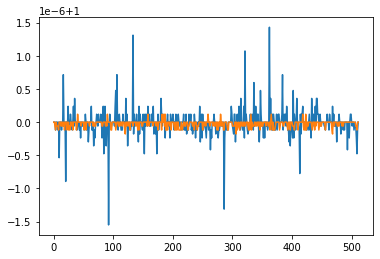

In [52]:
import matplotlib.pyplot as plt
test_eeg_features_avg2 = (test_eeg_features_avg - test_eeg_features_avg.mean(0))/ test_eeg_features_avg.std(0)
test_image_features_avg2 = (test_image_features_avg - test_image_features_avg.mean(0)) / test_image_features_avg.std(0)

print(test_eeg_features_avg2.std(0))
print(test_image_features_avg2.std(0))
plt.plot(np.arange(len(test_eeg_features_avg2[0])), test_eeg_features_avg2.std(0).cpu())
plt.plot(np.arange(len(test_image_features_avg2[0])), test_image_features_avg2.std(0).cpu())
plt.show()

In [71]:
acc, mat = evaluate(test_eeg_features_avg2, test_image_features_avg2)

Similarity Acc 0.7559183673469387


In [107]:
unit_corr = []
for i in range(val_image_features.shape[1]):
    corr = np.corrcoef(val_image_features[:,i].cpu(), val_eeg_features[:,i].cpu())[0,1]
    unit_corr.append(corr)
print(np.argsort(unit_corr)[::-1])
unit_indices = np.argsort(unit_corr)[::-1][:100]

[411 406 382 280 203 505 184  38 449  39 189 443   0 481  11 134 131 500
 507  74 109 194 484  81 315 483 265 219 154  82 459  50 125 201   1 349
 461 221 251 358  26 310 273 278 465 193 124 254 448 181 237   2  18 292
 508  57  34 434  71 464  60 429 497 233 240  20 236  85  31 207 136  67
 329 426  32 198 487 183 322 491  62 403 316 242 352  77  12 143 327 163
 385 270 462 199 369 356 377 267 388 204 103 175 111 252 148 489 400 146
 476 129 325 123 127 107  45  44 404 480 389 281 178  96 245 209 342  29
 205 274 159 457 196 144 153 440 368  35 283 511 307 126 338 372 421 216
 258 416 348 340 350 160  10  46   8 158 373 407 376 206 149 479 415 351
 214 428  78  66 305 370 345 156 371 110 341 510 478 463  23  72 243 161
 353 211 320  70 438 363 299 155 408 452 282   5 503  99  75 374 359 362
 276 226 381 262 496 250 168 147 284  25  27 230  15 422  76 379 291 142
 326 447 195 128 227 290 269 453  98 190 295 312 297 260 179 294 197 456
 435 263 355 138 333 451 437 241 328 162 266 455  9

In [111]:
unit_indices

array([411, 406, 382, 280, 203, 505, 184,  38, 449,  39, 189, 443,   0,
       481,  11, 134, 131, 500, 507,  74, 109, 194, 484,  81, 315, 483,
       265, 219, 154,  82, 459,  50, 125, 201,   1, 349, 461, 221, 251,
       358,  26, 310, 273, 278, 465, 193, 124, 254, 448, 181, 237,   2,
        18, 292, 508,  57,  34, 434,  71, 464,  60, 429, 497, 233, 240,
        20, 236,  85,  31, 207, 136,  67, 329, 426,  32, 198, 487, 183,
       322, 491,  62, 403, 316, 242, 352,  77,  12, 143, 327, 163, 385,
       270, 462, 199, 369, 356, 377, 267, 388, 204])

In [121]:
unit_corr = []
for i in range(val_image_features.shape[1]):
    corr = np.corrcoef(val_image_features[:,i].cpu(), val_eeg_features[:,i].cpu())[0,1]
    unit_corr.append(corr)

unit_indices = np.argsort(unit_corr)[::-1][:150]

target_latent = torch.cat([test_image_features, val_image_features], axis=0)
target_latent_std =  target_latent.std(0)
target_latent_mean = target_latent.mean(0)

source_latent = test_eeg_features
source_latent_std = source_latent.std(0)
source_latent_mean = source_latent.mean(0)
source_latent = (source_latent - source_latent_mean)/source_latent_std
source_latent = (source_latent * target_latent_std + target_latent_mean)
print('mean: ', target_latent_mean.mean(), source_latent_mean.mean())
print('std: ', target_latent_std.mean(), source_latent_std.mean())

source_latent = torch.from_numpy(source_latent.cpu().numpy()[:, unit_indices])# torch.from_numpy()
target_latent = torch.from_numpy(target_latent.cpu().numpy()[:,unit_indices])
acc, mat = evaluate(source_latent, target_latent)
print(mat)
print(mat[0])
print('acc', np.mean(np.sum(mat > 0, 1) / (len(target_latent)-1)))
print(np.sum(mat < 0, 1))
print('top1: ',  np.mean(np.sum(mat < 0, 1) < 1))
print('top5: ', np.mean(np.sum(mat < 0, 1) < 5))
print('top10: ', np.mean(np.sum(mat < 0, 1) < 10))


mean:  tensor(-0.0061, device='cuda:0') tensor(-0.0070, device='cuda:0')
std:  tensor(1.0513, device='cuda:0') tensor(0.1333, device='cuda:0')
Similarity Acc 0.6231665554814322
[[ 0. -1. -1. ... -1. -1. -1.]
 [ 1.  0.  1. ...  1.  1.  1.]
 [ 1.  1.  0. ...  1.  1.  1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
[ 0. -1. -1. ... -1. -1. -1.]
acc 0.6231665554814322
[ 943  531  185  860 1237 1294  871  216  491 1343 1192  687  530   32
  645  346  853  802  753  411  576   10    6  206   32  344  277  715
  330  827 1172 1098  948  412  650  377  160  464 1449  812  482  614
  558  429  663   58 1280   81  173  850  846  302   57  858  710 1399
 1255  140  438  353  453  158  156  732  723  480  472 1109  823  147
   80  545  682   24  750 1175  156  251 1305  938   22  228   52    3
  582  498 1428  469  271 1047  186  244  338  518  791  405  336  408
  300   84   96   68  157  258   28 1265  996 1039   13  687  712 1406
  238  456

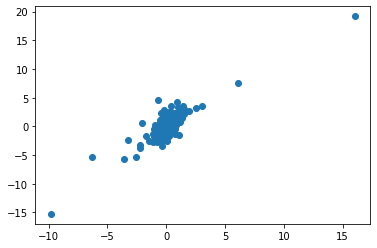

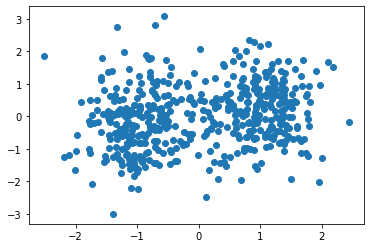

[Similarities]: 100%|██████████| 50/50 [00:00<00:00, 143.05it/s]

similarity torch.Size([50, 50])
Top1:  0.04000, Top10: 0.52000


In [60]:
test_eeg_features_avg2 = (test_eeg_features_avg - test_eeg_features_avg.mean(0))/ test_eeg_features_avg.std(0)
test_image_features_avg2 = (test_image_features_avg - test_image_features_avg.mean(0)) / test_image_features_avg.std(0)
# plt.plot(np.arange(len(test_eeg_features_avg2[0])), test_eeg_features_avg2[0].cpu())
# plt.plot(np.arange(len(test_image_features_avg2[0])), test_image_features_avg2[0].cpu())
plt.scatter(test_eeg_features_avg[0].cpu(), test_image_features_avg[0].cpu())
plt.show()
plt.scatter(test_eeg_features_avg2[0].cpu(), test_image_features_avg2[0].cpu())
plt.show()
testAvgTop1acc, testAvgTop10acc = classifier(test_eeg_features_avg2, test_image_features_avg2, test=True)
print(f'Top1: {testAvgTop1acc: .5f}, Top10: {testAvgTop10acc:.5f}')

In [70]:
corrs = []
for i in range(len(test_eeg_features_avg2)):
    corr = np.corrcoef(test_eeg_features_avg2[i].cpu(), test_image_features_avg2[i].cpu())[0,1]
    corrs.append(corr)
print(np.mean(corrs))

0.14427091965832087
